<a href="https://colab.research.google.com/github/hemanthp04/Predicting-market-volatility-using-data-from-Reddit-s-WallStreetBets/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas numpy scikit-learn torch textblob vaderSentiment matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Stock data
import yfinance as yf

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
from google.colab import files
import io

# Upload the CSV file
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]
print(f"\n✅ File '{filename}' uploaded successfully!")

# Load the data with error handling for encoding
try:
    df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
except UnicodeDecodeError:
    print(f"UTF-8 decoding failed for {filename}. Trying 'latin1' encoding...")
    try:
        df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')
        print(f"✅ File '{filename}' loaded successfully with 'latin1' encoding.")
    except Exception as e:
        print(f"❌ Failed to load file '{filename}' with 'latin1' encoding: {e}")
        df = None # Ensure df is None if loading fails


if df is not None:
    print(f"\n📊 Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nFirst few rows:")
    display(df.head())
else:
    print("\n❌ Data loading failed. Please check the file and try again.")

Saving reddit_wsb.csv to reddit_wsb.csv

✅ File 'reddit_wsb.csv' uploaded successfully!

📊 Dataset shape: (53482, 12)
Columns: ['title', 'score', 'id', 'url', 'comms_num', 'created', 'body', 'timestamp', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']

First few rows:


,title,score,id,url,comms_num,created,body,timestamp,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1611862661,NaN,28-01-2021 21:37,NaN,NaN,NaN,NaN
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1611862330,NaN,28-01-2021 21:32,NaN,NaN,NaN,NaN
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1611862235,The CEO of NASDAQ pushed to halt trading “to g...,28-01-2021 21:30,NaN,NaN,NaN,NaN
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1611862137,NaN,28-01-2021 21:28,NaN,NaN,NaN,NaN
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1611862016,NaN,28-01-2021 21:26,NaN,NaN,NaN,NaN


In [4]:
# Basic data exploration
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nTotal posts: {len(df):,}")
print(f"\nColumn info:")
print(df.info())

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
print(df.isnull().sum())

print("\n" + "="*60)
print("SAMPLE DATA")
print("="*60)
print(df.head(3))

# Check date range
# df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
# print(f"\n📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

DATASET OVERVIEW

Total posts: 53,482

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53482 entries, 0 to 53481
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        53349 non-null  object
 1   score        53281 non-null  object
 2   id           53258 non-null  object
 3   url          53244 non-null  object
 4   comms_num    53225 non-null  object
 5   created      53215 non-null  object
 6   body         24759 non-null  object
 7   timestamp    53184 non-null  object
 8   Unnamed: 8   7 non-null      object
 9   Unnamed: 9   7 non-null      object
 10  Unnamed: 10  4 non-null      object
 11  Unnamed: 11  2 non-null      object
dtypes: object(12)
memory usage: 4.9+ MB
None

MISSING VALUES
title            133
score            201
id               224
url              238
comms_num        257
created          267
body           28723
timestamp        298
Unnamed: 8     53475
Unnamed: 9    

In [5]:
def extract_tickers(text):
    """
    Extract stock tickers mentioned in text
    Focus on the main stocks from the paper: GME, AMC, TSLA
    Plus other popular WSB stocks
    """
    if pd.isna(text):
        return []

    text = str(text).upper()

    # Main tickers to focus on (from the paper)
    primary_tickers = ['GME', 'AMC', 'TSLA']

    # Additional popular WSB tickers from that period
    secondary_tickers = ['BB', 'NOK', 'BBBY', 'EXPR', 'KOSS', 'NAKD', 'SNDL', 'FB']

    all_tickers = primary_tickers + secondary_tickers

    mentioned = []
    for ticker in all_tickers:
        # Use word boundaries to avoid false matches
        pattern = r'\b' + ticker + r'\b'
        if re.search(pattern, text):
            mentioned.append(ticker)

    return mentioned

# Apply ticker extraction to both title and body
print("🔍 Extracting stock tickers from posts...")
df['tickers_title'] = df['title'].apply(extract_tickers)
df['tickers_body'] = df['body'].apply(extract_tickers)

# Combine tickers from both title and body
df['tickers'] = df.apply(lambda row: list(set(row['tickers_title'] + row['tickers_body'])), axis=1)

# Count posts per ticker
ticker_counts = {}
for tickers_list in df['tickers']:
    for ticker in tickers_list:
        ticker_counts[ticker] = ticker_counts.get(ticker, 0) + 1

print("\n📊 Posts mentioning each stock:")
for ticker, count in sorted(ticker_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{ticker}: {count:,} posts")

# Filter to posts that mention at least one stock
df_with_tickers = df[df['tickers'].apply(len) > 0].copy()
print(f"\n✅ Posts mentioning stocks: {len(df_with_tickers):,} out of {len(df):,}")

🔍 Extracting stock tickers from posts...

📊 Posts mentioning each stock:
GME: 13,584 posts
AMC: 5,336 posts
BB: 2,216 posts
NOK: 1,695 posts
TSLA: 602 posts
SNDL: 398 posts
NAKD: 320 posts
BBBY: 121 posts
FB: 106 posts
KOSS: 91 posts
EXPR: 68 posts

✅ Posts mentioning stocks: 18,042 out of 53,482


In [6]:
# Initialize VADER sentiment analyzer (better for social media)
vader = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    """
    Get sentiment scores using VADER
    Returns positive, neutral, negative scores
    """
    if pd.isna(text) or str(text).strip() == '':
        return {'positive': 0, 'neutral': 1, 'negative': 0}

    try:
        scores = vader.polarity_scores(str(text))

        # VADER returns compound, pos, neu, neg
        # We'll use pos, neu, neg directly
        return {
            'positive': scores['pos'],
            'neutral': scores['neu'],
            'negative': scores['neg']
        }
    except:
        return {'positive': 0, 'neutral': 1, 'negative': 0}

print("🎭 Performing sentiment analysis on posts...")
print("This may take a few minutes for large datasets...\n")

# Apply sentiment analysis to body text
sentiments = df_with_tickers['body'].progress_apply(get_sentiment_scores) if 'progress_apply' in dir(df_with_tickers['body']) else df_with_tickers['body'].apply(get_sentiment_scores)

df_with_tickers['positive_sentiment'] = sentiments.apply(lambda x: x['positive'])
df_with_tickers['neutral_sentiment'] = sentiments.apply(lambda x: x['neutral'])
df_with_tickers['negative_sentiment'] = sentiments.apply(lambda x: x['negative'])

print("✅ Sentiment analysis complete!")
print(f"\nAverage sentiment scores:")
print(f"Positive: {df_with_tickers['positive_sentiment'].mean():.3f}")
print(f"Neutral: {df_with_tickers['neutral_sentiment'].mean():.3f}")
print(f"Negative: {df_with_tickers['negative_sentiment'].mean():.3f}")

🎭 Performing sentiment analysis on posts...
This may take a few minutes for large datasets...

✅ Sentiment analysis complete!

Average sentiment scores:
Positive: 0.065
Neutral: 0.888
Negative: 0.048


In [8]:
# Create the exact 7 features from the paper
print("🔧 Creating feature vectors...")

df_with_tickers['post_score'] = df_with_tickers['score']
df_with_tickers['total_comms_num'] = df_with_tickers['comms_num']
df_with_tickers['len_of_post'] = df_with_tickers['body'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
df_with_tickers['bias'] = 1

# Convert 'timestamp' to datetime, coercing errors
df_with_tickers['timestamp'] = pd.to_datetime(df_with_tickers['timestamp'], errors='coerce')

# Extract date (without time) for grouping
df_with_tickers['date'] = df_with_tickers['timestamp'].dt.date

# Explode the dataframe so each ticker gets its own row
df_exploded = df_with_tickers.explode('tickers').copy()
df_exploded = df_exploded[df_exploded['tickers'].notna()]

print(f"✅ Exploded dataset shape: {df_exploded.shape}")
print(f"Unique stocks: {df_exploded['tickers'].unique()}")
# Filter out NaN values from the date column before finding min and max
valid_dates = df_exploded['date'].dropna()
if not valid_dates.empty:
    print(f"Date range: {valid_dates.min()} to {valid_dates.max()}")
else:
    print("No valid dates found in the dataset.")


# The 7 features
feature_columns = [
    'post_score',
    'total_comms_num',
    'len_of_post',
    'positive_sentiment',
    'neutral_sentiment',
    'negative_sentiment',
    'bias'
]

print(f"\n📋 Features: {feature_columns}")

🔧 Creating feature vectors...
✅ Exploded dataset shape: (24537, 23)
Unique stocks: ['GME' 'AMC' 'BB' 'NOK' 'TSLA' 'BBBY' 'EXPR' 'KOSS' 'NAKD' 'SNDL' 'FB']
Date range: 2020-09-29 to 2021-08-16

📋 Features: ['post_score', 'total_comms_num', 'len_of_post', 'positive_sentiment', 'neutral_sentiment', 'negative_sentiment', 'bias']


In [9]:
# Group by stock ticker and date, then aggregate features
print("📊 Aggregating daily features for each stock...")

# Convert 'post_score' and 'total_comms_num' to numeric, coercing errors
df_exploded['post_score'] = pd.to_numeric(df_exploded['post_score'], errors='coerce')
df_exploded['total_comms_num'] = pd.to_numeric(df_exploded['total_comms_num'], errors='coerce')

# Aggregate by taking the mean of all posts for that stock on that day
daily_data = df_exploded.groupby(['tickers', 'date'])[feature_columns].mean().reset_index()

print(f"\n✅ Daily aggregated data shape: {daily_data.shape}")
print(f"\nPosts per stock per day:")
posts_per_day = df_exploded.groupby(['tickers', 'date']).size().reset_index(name='num_posts')
print(posts_per_day.groupby('tickers')['num_posts'].describe())

# Show sample
print("\nSample daily features:")
daily_data.head(10)

📊 Aggregating daily features for each stock...

✅ Daily aggregated data shape: (892, 9)

Posts per stock per day:
         count       mean         std  min  25%  50%    75%     max
tickers                                                            
AMC      169.0  31.550296  179.371386  1.0  2.0  5.0  12.00  2272.0
BB       133.0  16.639098  106.656723  1.0  2.0  3.0   6.00  1226.0
BBBY      27.0   4.481481   12.125531  1.0  1.0  1.0   2.50    64.0
EXPR       7.0   9.714286   20.138804  1.0  1.0  1.0   4.50    55.0
FB        72.0   1.472222    0.768614  1.0  1.0  1.0   2.00     4.0
GME      170.0  79.876471  379.976007  1.0  3.0  9.0  39.75  4660.0
KOSS       8.0  11.375000   25.382432  1.0  1.0  2.0   4.00    74.0
NAKD      10.0  32.000000   88.079510  1.0  1.0  1.5   5.25   282.0
NOK       81.0  20.925926  121.118204  1.0  1.0  2.0   4.00  1086.0
SNDL      76.0   5.223684   25.627381  1.0  1.0  1.0   2.00   224.0
TSLA     139.0   4.330935    4.074289  1.0  2.0  3.0   5.00    24.0

S

,tickers,date,post_score,total_comms_num,len_of_post,positive_sentiment,neutral_sentiment,negative_sentiment,bias
0,AMC,2021-01-28,329.264151,63.344340,325.627358,0.057816,0.884203,0.057991,1.0
1,AMC,2021-01-29,90.937060,12.456866,225.206426,0.060967,0.881270,0.057766,1.0
2,AMC,2021-01-30,2528.953333,289.346667,1233.973333,0.069333,0.873987,0.056633,1.0
3,AMC,2021-01-31,3460.144330,383.113402,1806.494845,0.070031,0.876082,0.053948,1.0
4,AMC,2021-02-01,2800.528736,280.793103,1951.735632,0.066885,0.890931,0.042149,1.0
5,AMC,2021-02-02,1104.830645,109.201613,1024.411290,0.047702,0.920298,0.032032,1.0
6,AMC,2021-02-03,912.107884,85.618257,660.394191,0.046909,0.915755,0.037340,1.0
7,AMC,2021-02-04,706.743842,62.192118,636.980296,0.071936,0.886310,0.041754,1.0
8,AMC,2021-02-05,79.662420,17.780255,515.541401,0.084866,0.850115,0.065054,1.0
9,AMC,2021-02-06,110.372483,26.463087,543.573826,0.072970,0.879218,0.047849,1.0


In [10]:
def get_stock_price_labels(ticker, dates):
    """
    Fetch stock prices and create binary labels with better error handling
    Label = 1 if next day opening price > today's opening price
    Label = 0 otherwise
    """
    try:
        print(f"  📊 Fetching data for {ticker}...")

        # Convert dates to datetime if they aren't already
        dates_dt = [pd.to_datetime(d) if not isinstance(d, pd.Timestamp) else d for d in dates]

        # Get stock data with wider date range
        start_date = min(dates_dt) - timedelta(days=10)
        end_date = max(dates_dt) + timedelta(days=10)

        print(f"     Date range: {start_date.date()} to {end_date.date()}")

        # Try to fetch data
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date, auto_adjust=False)

        if len(hist) == 0:
            print(f"  ❌ No price data found for {ticker}")
            return [None] * len(dates), [None] * len(dates), [None] * len(dates)

        print(f"     ✅ Got {len(hist)} days of price data")

        # Make sure index is timezone-naive for comparison
        hist.index = hist.index.tz_localize(None)

        labels = []
        prices_today = []
        prices_next = []

        valid_count = 0

        for date in dates_dt:
            # Make date timezone-naive
            date = pd.to_datetime(date).tz_localize(None)

            try:
                # Find closest trading day on or before this date
                hist_before = hist[hist.index <= date]

                if len(hist_before) == 0:
                    labels.append(None)
                    prices_today.append(None)
                    prices_next.append(None)
                    continue

                # Get today's opening price
                today_idx = hist_before.index[-1]
                today_price = hist_before.loc[today_idx, 'Open']

                # Find next trading day after this date
                hist_after = hist[hist.index > date]

                if len(hist_after) == 0:
                    labels.append(None)
                    prices_today.append(None)
                    prices_next.append(None)
                    continue

                # Get next day's opening price
                next_idx = hist_after.index[0]
                next_price = hist_after.loc[next_idx, 'Open']

                # Create binary label: 1 if price went up, 0 if went down
                label = 1 if next_price > today_price else 0

                labels.append(label)
                prices_today.append(float(today_price))
                prices_next.append(float(next_price))
                valid_count += 1

            except Exception as e:
                labels.append(None)
                prices_today.append(None)
                prices_next.append(None)

        print(f"     ✅ Created {valid_count} valid labels out of {len(dates)} dates")
        return labels, prices_today, prices_next

    except Exception as e:
        print(f"  ❌ Error fetching {ticker}: {str(e)}")
        return [None] * len(dates), [None] * len(dates), [None] * len(dates)


# Fetch price data for each stock
print("💰 Fetching stock price data and creating labels...")
print("This may take a few minutes...\n")
print("="*70)

# Check which stocks we have
available_tickers = daily_data['tickers'].unique()
print(f"📋 Stocks in dataset: {list(available_tickers)}\n")

for ticker in available_tickers:
    print(f"\n{ticker}:")
    print("-" * 70)

    ticker_mask = daily_data['tickers'] == ticker
    dates = daily_data[ticker_mask]['date'].values

    labels, prices_today, prices_next = get_stock_price_labels(ticker, dates)

    daily_data.loc[ticker_mask, 'label'] = labels
    daily_data.loc[ticker_mask, 'price_today'] = prices_today
    daily_data.loc[ticker_mask, 'price_next'] = prices_next

print("\n" + "="*70)
print("📊 SUMMARY")
print("="*70)

# Check how many valid labels we got
print(f"\nTotal rows before filtering: {len(daily_data)}")
print(f"Rows with valid labels: {daily_data['label'].notna().sum()}")
print(f"Rows without labels: {daily_data['label'].isna().sum()}")

# Remove rows without labels
daily_data_clean = daily_data.dropna(subset=['label']).copy()

print(f"\n✅ Final dataset size: {len(daily_data_clean)} days\n")

if len(daily_data_clean) == 0:
    print("⚠️ WARNING: No valid data with labels!")
    print("\nPossible reasons:")
    print("1. The tickers in your dataset may not have price data for those dates")
    print("2. The dates might be outside trading hours or market was closed")
    print("3. Ticker symbols might be incorrect or stocks were delisted")
    print("\nLet's check what tickers were found in posts:")
    print(daily_data['tickers'].value_counts())
else:
    print(f"✅ SUCCESS! Data ready for training\n")
    print(f"Samples per stock:")
    samples_per_stock = daily_data_clean.groupby('tickers').size().sort_values(ascending=False)
    for ticker, count in samples_per_stock.items():
        print(f"  {ticker}: {count} days")

    print(f"\n📊 Label distribution (1=up, 0=down):")
    label_counts = daily_data_clean.groupby('tickers')['label'].value_counts()
    print(label_counts)

💰 Fetching stock price data and creating labels...
This may take a few minutes...

📋 Stocks in dataset: ['AMC', 'BB', 'BBBY', 'EXPR', 'FB', 'GME', 'KOSS', 'NAKD', 'NOK', 'SNDL', 'TSLA']


AMC:
----------------------------------------------------------------------
  📊 Fetching data for AMC...
     Date range: 2021-01-18 to 2021-08-26
     ✅ Got 153 days of price data
     ✅ Created 169 valid labels out of 169 dates

BB:
----------------------------------------------------------------------
  📊 Fetching data for BB...
     Date range: 2021-01-18 to 2021-08-23
     ✅ Got 150 days of price data
     ✅ Created 133 valid labels out of 133 dates

BBBY:
----------------------------------------------------------------------
  📊 Fetching data for BBBY...
     Date range: 2021-01-18 to 2021-07-24
     ✅ Got 130 days of price data
     ✅ Created 27 valid labels out of 27 dates

EXPR:
----------------------------------------------------------------------
  📊 Fetching data for EXPR...
     Date rang

ERROR:yfinance:$EXPR: possibly delisted; no timezone found


  ❌ No price data found for EXPR

FB:
----------------------------------------------------------------------
  📊 Fetching data for FB...
     Date range: 2021-01-19 to 2021-08-16


ERROR:yfinance:$FB: possibly delisted; no price data found  (1d 2021-01-19 00:00:00 -> 2021-08-16 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1611032400, endDate = 1629086400")


  ❌ No price data found for FB

GME:
----------------------------------------------------------------------
  📊 Fetching data for GME...
     Date range: 2021-01-18 to 2021-08-24
     ✅ Got 151 days of price data
     ✅ Created 170 valid labels out of 170 dates

KOSS:
----------------------------------------------------------------------
  📊 Fetching data for KOSS...
     Date range: 2021-01-18 to 2021-03-21
     ✅ Got 43 days of price data
     ✅ Created 8 valid labels out of 8 dates

NAKD:
----------------------------------------------------------------------
  📊 Fetching data for NAKD...
     Date range: 2021-01-18 to 2021-07-12


ERROR:yfinance:$NAKD: possibly delisted; no timezone found


  ❌ No price data found for NAKD

NOK:
----------------------------------------------------------------------
  📊 Fetching data for NOK...
     Date range: 2021-01-18 to 2021-08-23
     ✅ Got 150 days of price data
     ✅ Created 81 valid labels out of 81 dates

SNDL:
----------------------------------------------------------------------
  📊 Fetching data for SNDL...
     Date range: 2021-01-18 to 2021-08-23
     ✅ Got 150 days of price data
     ✅ Created 76 valid labels out of 76 dates

TSLA:
----------------------------------------------------------------------
  📊 Fetching data for TSLA...
     Date range: 2020-09-19 to 2021-08-21
     ✅ Got 232 days of price data
     ✅ Created 139 valid labels out of 139 dates

📊 SUMMARY

Total rows before filtering: 892
Rows with valid labels: 803
Rows without labels: 89

✅ Final dataset size: 803 days

✅ SUCCESS! Data ready for training

Samples per stock:
  GME: 170 days
  AMC: 169 days
  TSLA: 139 days
  BB: 133 days
  NOK: 81 days
  SNDL: 76

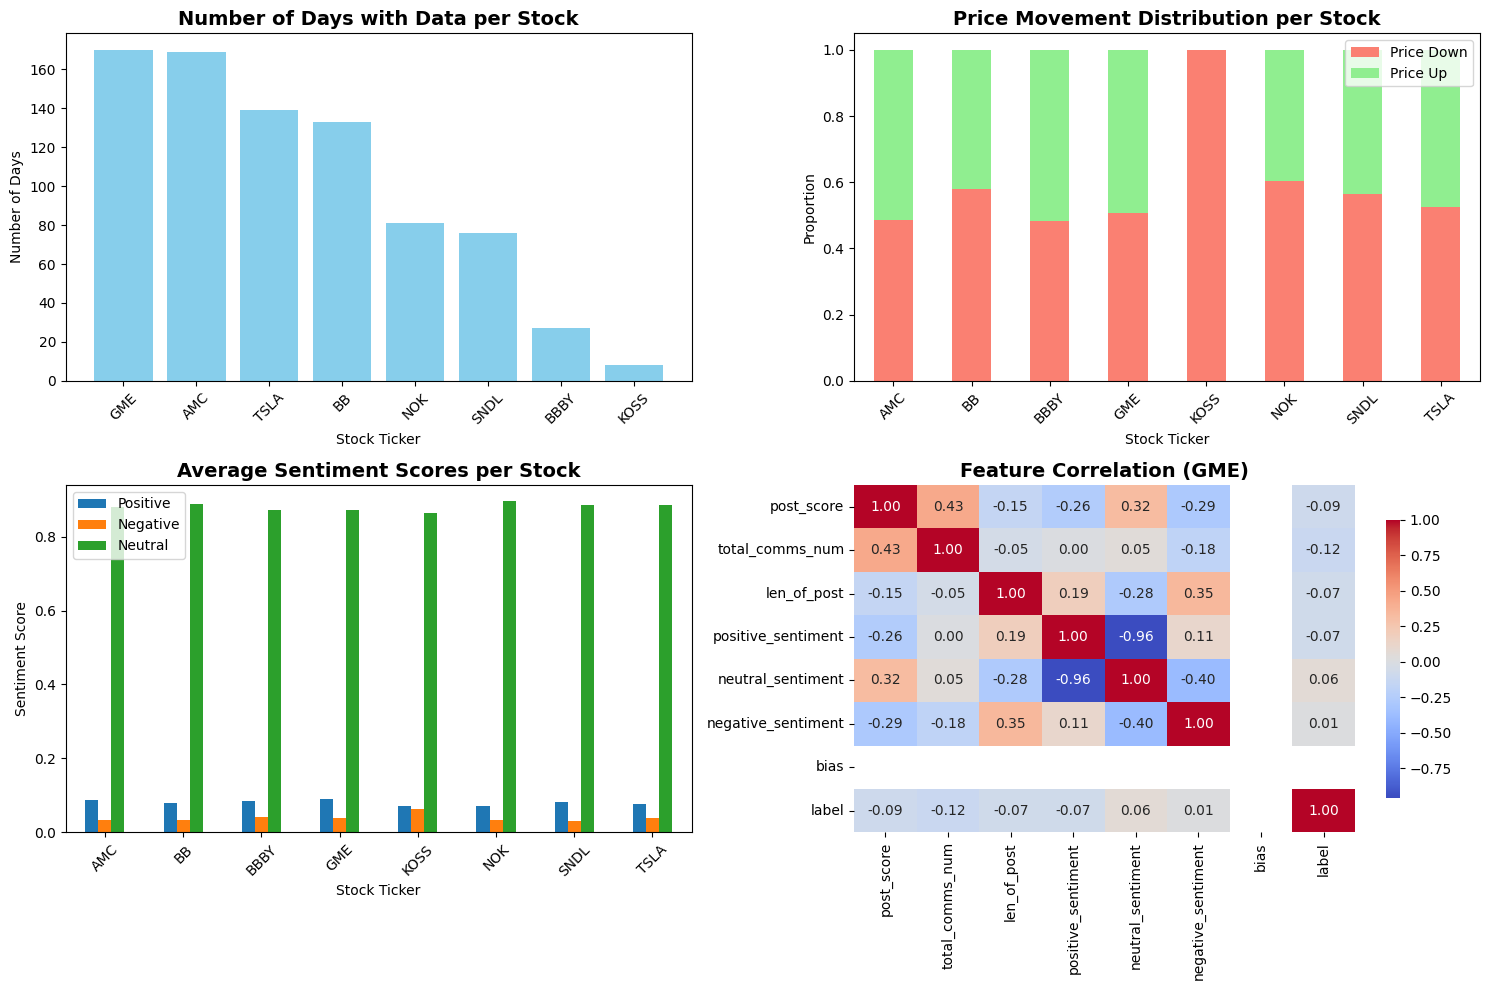

✅ Visualizations complete!


In [11]:
# Visualization of ticker mentions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Posts per stock
ticker_counts_df = daily_data_clean.groupby('tickers').size().sort_values(ascending=False)
axes[0, 0].bar(ticker_counts_df.index, ticker_counts_df.values, color='skyblue')
axes[0, 0].set_title('Number of Days with Data per Stock', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Stock Ticker')
axes[0, 0].set_ylabel('Number of Days')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Label distribution
label_dist = daily_data_clean.groupby('tickers')['label'].value_counts(normalize=True).unstack()
label_dist.plot(kind='bar', stacked=True, ax=axes[0, 1], color=['salmon', 'lightgreen'])
axes[0, 1].set_title('Price Movement Distribution per Stock', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Stock Ticker')
axes[0, 1].set_ylabel('Proportion')
axes[0, 1].legend(['Price Down', 'Price Up'])
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Average sentiment per stock
sentiment_cols = ['positive_sentiment', 'negative_sentiment', 'neutral_sentiment']
sentiment_means = daily_data_clean.groupby('tickers')[sentiment_cols].mean()
sentiment_means.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Average Sentiment Scores per Stock', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Stock Ticker')
axes[1, 0].set_ylabel('Sentiment Score')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(['Positive', 'Negative', 'Neutral'])

# 4. Feature correlation heatmap (for GME)
if 'GME' in daily_data_clean['tickers'].values:
    gme_data = daily_data_clean[daily_data_clean['tickers'] == 'GME'][feature_columns + ['label']]
    corr = gme_data.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 1], cbar_kws={'shrink': 0.8})
    axes[1, 1].set_title('Feature Correlation (GME)', fontsize=14, fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'GME data not available', ha='center', va='center')

plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")

In [12]:
class StockPredictorNN(nn.Module):
    """
    3-layer neural network as described in the paper:
    - Input: 7 features
    - Hidden layers: 256 units each with ReLU
    - Output: 1 unit with Sigmoid (binary classification)
    """
    def __init__(self, input_size=7):
        super(StockPredictorNN, self).__init__()

        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

print("✅ Neural Network model defined!")
print("\nModel architecture:")
model = StockPredictorNN()
print(model)

✅ Neural Network model defined!

Model architecture:
StockPredictorNN(
  (fc1): Linear(in_features=7, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [13]:
def train_neural_network(X_train, y_train, X_val, y_val, epochs=30, batch_size=16, learning_rate=0.001):
    """
    Train the neural network with the given parameters
    """
    # Convert to PyTorch tensors
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.FloatTensor(y_val).reshape(-1, 1)

    # Initialize model
    model = StockPredictorNN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training history
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0

        # Mini-batch training
        for i in range(0, len(X_train_t), batch_size):
            batch_X = X_train_t[i:i+batch_size]
            batch_y = y_train_t[i:i+batch_size]

            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t).item()
            val_losses.append(val_loss)

            # Calculate accuracy
            val_predictions = (val_outputs > 0.5).float()
            val_acc = (val_predictions == y_val_t).float().mean().item()
            val_accuracies.append(val_acc)

        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model, train_losses, val_losses, val_accuracies

print("✅ Training function defined!")

✅ Training function defined!



  TRAINING MODELS FOR GME

📊 Total samples: 170
   - Price went up: 84 (49.4%)
   - Price went down: 86 (50.6%)

📦 Data split:
   - Train: 136 samples
   - Validation: 17 samples
   - Test: 17 samples

----------------------------------------------------------------------
🎲 RANDOM BASELINE
----------------------------------------------------------------------
Accuracy: 0.529

----------------------------------------------------------------------
📈 LOGISTIC REGRESSION
----------------------------------------------------------------------
Accuracy: 0.706

Classification Report:
              precision    recall  f1-score   support

        Down       1.00      0.44      0.62         9
          Up       0.62      1.00      0.76         8

    accuracy                           0.71        17
   macro avg       0.81      0.72      0.69        17
weighted avg       0.82      0.71      0.68        17


----------------------------------------------------------------------
🧠 NEURAL NETWORK


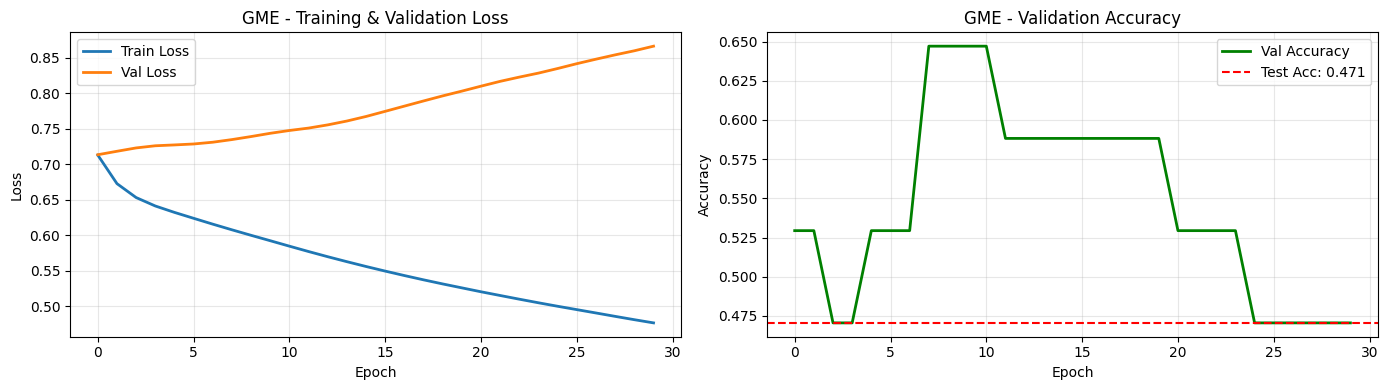


  TRAINING MODELS FOR AMC

📊 Total samples: 169
   - Price went up: 87 (51.5%)
   - Price went down: 82 (48.5%)

📦 Data split:
   - Train: 135 samples
   - Validation: 17 samples
   - Test: 17 samples

----------------------------------------------------------------------
🎲 RANDOM BASELINE
----------------------------------------------------------------------
Accuracy: 0.529

----------------------------------------------------------------------
📈 LOGISTIC REGRESSION
----------------------------------------------------------------------
Accuracy: 0.647

Classification Report:
              precision    recall  f1-score   support

        Down       0.67      0.50      0.57         8
          Up       0.64      0.78      0.70         9

    accuracy                           0.65        17
   macro avg       0.65      0.64      0.64        17
weighted avg       0.65      0.65      0.64        17


----------------------------------------------------------------------
🧠 NEURAL NETWORK


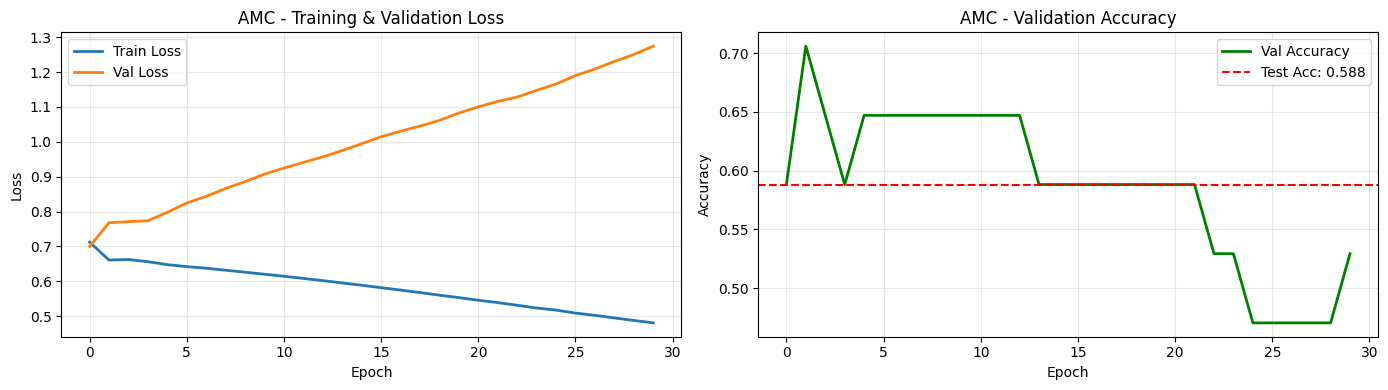


  TRAINING MODELS FOR TSLA

📊 Total samples: 139
   - Price went up: 66 (47.5%)
   - Price went down: 73 (52.5%)

📦 Data split:
   - Train: 111 samples
   - Validation: 14 samples
   - Test: 14 samples

----------------------------------------------------------------------
🎲 RANDOM BASELINE
----------------------------------------------------------------------
Accuracy: 0.500

----------------------------------------------------------------------
📈 LOGISTIC REGRESSION
----------------------------------------------------------------------
Accuracy: 0.571

Classification Report:
              precision    recall  f1-score   support

        Down       0.60      0.43      0.50         7
          Up       0.56      0.71      0.62         7

    accuracy                           0.57        14
   macro avg       0.58      0.57      0.56        14
weighted avg       0.58      0.57      0.56        14


----------------------------------------------------------------------
🧠 NEURAL NETWORK

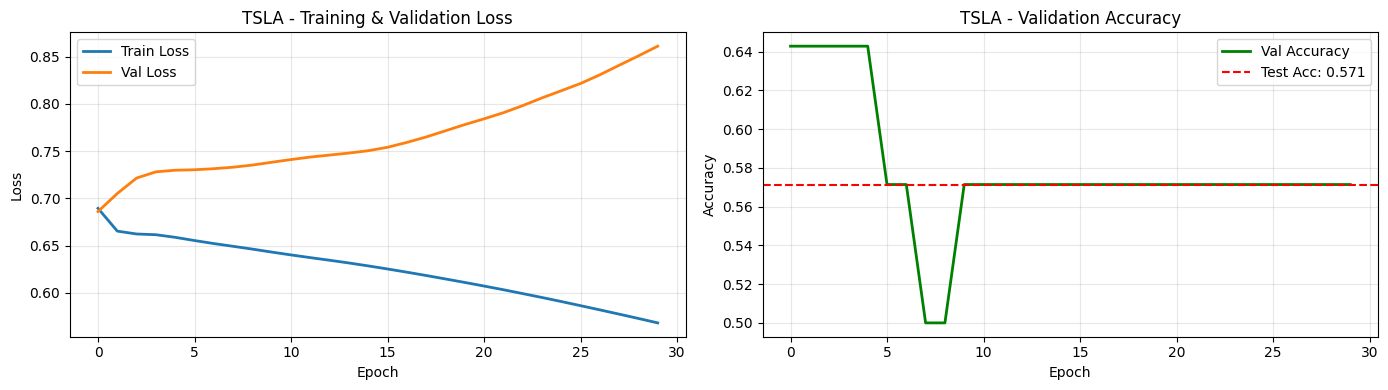


✅ ALL TRAINING COMPLETE!


In [15]:
# Focus on the three main stocks from the paper
main_stocks = ['GME', 'AMC', 'TSLA']

# Store results
all_results = []

for ticker in main_stocks:
    if ticker not in daily_data_clean['tickers'].values:
        print(f"\n⚠️ Skipping {ticker} - no data available in daily_data_clean")
        continue

    print(f"\n{'='*70}")
    print(f"{'='*70}")
    print(f"  TRAINING MODELS FOR {ticker}")
    print(f"{'='*70}")
    print(f"{'='*70}\n")

    # Get data for this stock and filter out any rows with None labels
    stock_data = daily_data_clean[daily_data_clean['tickers'] == ticker].dropna(subset=['label']).copy()

    # Prepare features and labels
    X = stock_data[feature_columns].values
    y = stock_data['label'].values.astype(int) # Ensure labels are integers

    print(f"📊 Total samples: {len(X)}")
    print(f"   - Price went up: {np.sum(y == 1)} ({np.mean(y)*100:.1f}%)")
    print(f"   - Price went down: {np.sum(y == 0)} ({(1-np.mean(y))*100:.1f}%)")

    # Check if we have enough data
    if len(X) < 20:
        print(f"⚠️ Not enough data for {ticker} (need at least 20 samples)")
        continue

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split: 80% train, 10% validation, 10% test
    # Ensure stratification is used only if there are at least two unique classes
    stratify_train = y if len(np.unique(y)) > 1 else None


    X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify=stratify_train)

    # Ensure stratification is used only if there are at least two unique classes
    stratify_temp = y_temp if len(np.unique(y_temp)) > 1 else None
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.111, random_state=42, stratify=stratify_temp)

    print(f"\n📦 Data split:")
    print(f"   - Train: {len(X_train)} samples")
    print(f"   - Validation: {len(X_val)} samples")
    print(f"   - Test: {len(X_test)} samples")

    # ====================
    # 1. RANDOM BASELINE
    # ====================
    print(f"\n{'-'*70}")
    print("🎲 RANDOM BASELINE")
    print(f"{'-'*70}")

    random_predictions = np.random.randint(0, 2, size=len(y_test))
    random_acc = accuracy_score(y_test, random_predictions)
    print(f"Accuracy: {random_acc:.3f}")

    # ====================
    # 2. LOGISTIC REGRESSION
    # ====================
    print(f"\n{'-'*70}")
    print("📈 LOGISTIC REGRESSION")
    print(f"{'-'*70}")

    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg.fit(X_train, y_train)

    log_reg_pred = log_reg.predict(X_test)
    log_reg_acc = accuracy_score(y_test, log_reg_pred)

    print(f"Accuracy: {log_reg_acc:.3f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, log_reg_pred, target_names=['Down', 'Up']))

    # ====================
    # 3. NEURAL NETWORK
    # ====================
    print(f"\n{'-'*70}")
    print("🧠 NEURAL NETWORK")
    print(f"{'-'*70}")

    # Adjust batch size if needed (like they did for TSLA/GME)
    batch_size = 64 if ticker in ['TSLA', 'GME'] and len(X_train) > 100 else 16
    print(f"Batch size: {batch_size}")
    print(f"Training for 30 epochs with Adam optimizer (lr=0.001)...\n")

    nn_model, train_losses, val_losses, val_accuracies = train_neural_network(
        X_train, y_train, X_val, y_val,
        epochs=30, batch_size=batch_size, learning_rate=0.001
    )

    # Test the neural network
    nn_model.eval()
    with torch.no_grad():
        X_test_t = torch.FloatTensor(X_test)
        y_test_t = torch.FloatTensor(y_test).reshape(-1, 1)

        test_outputs = nn_model(X_test_t)
        test_predictions = (test_outputs > 0.5).float()
        nn_acc = (test_predictions == y_test_t).float().mean().item()

    print(f"\n✅ Final Test Accuracy: {nn_acc:.3f}")

    # Convert predictions for classification report
    nn_pred_np = test_predictions.numpy().flatten().astype(int)
    print(f"\nClassification Report:")
    print(classification_report(y_test, nn_pred_np, target_names=['Down', 'Up']))

    # Store results
    all_results.append({
        'Stock': ticker,
        'Samples': len(X),
        'Random Baseline': f"{random_acc:.3f}",
        'Logistic Regression': f"{log_reg_acc:.3f}",
        'Neural Network': f"{nn_acc:.3f}"
    })

    # Plot training curves
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0].plot(val_losses, label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{ticker} - Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(val_accuracies, label='Val Accuracy', color='green', linewidth=2)
    axes[1].axhline(y=nn_acc, color='red', linestyle='--', label=f'Test Acc: {nn_acc:.3f}')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'{ticker} - Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print(f"\n{'='*70}")
print("✅ ALL TRAINING COMPLETE!")
print(f"{'='*70}")

### Model Performance Comparison

Below is a summary of the accuracy for each model (Random Baseline, Logistic Regression, and Neural Network) for the main stocks analyzed:

In [16]:
results_df = pd.DataFrame(all_results)
print("📊 Model Performance Summary:")
display(results_df)

📊 Model Performance Summary:


,Stock,Samples,Random Baseline,Logistic Regression,Neural Network
0,GME,170,0.529,0.706,0.471
1,AMC,169,0.529,0.647,0.588
2,TSLA,139,0.500,0.571,0.571


In [17]:
# Create results dataframe
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print(" "*25 + "FINAL RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Compare with paper results
print("\n" + "="*80)
print("COMPARISON WITH PAPER RESULTS")
print("="*80)

paper_results = {
    'Stock': ['TSLA', 'AMC', 'GME', 'FB'],
    'Paper NN Accuracy': [0.64, 0.819, 0.844, 0.693],
    'Paper LogReg Accuracy': [0.740, 'N/A', 0.719, 0.68],
    'Paper Baseline': [0.532, 0.42, 0.527, 0.42]
}

paper_df = pd.DataFrame(paper_results)
print(paper_df.to_string(index=False))
print("="*80)

print("\n📝 Notes:")
print("- The paper used only ~100 data points total (80 train, 20 test)")
print("- Your dataset has significantly more data, which should give more reliable results")
print("- Differences in accuracy are expected due to:")
print("  • Different time periods in the data")
print("  • More training samples in your dataset")
print("  • Different sentiment analysis methods")
print("  • Random initialization and data splits")


                         FINAL RESULTS SUMMARY
Stock  Samples Random Baseline Logistic Regression Neural Network
  GME      170           0.529               0.706          0.471
  AMC      169           0.529               0.647          0.588
 TSLA      139           0.500               0.571          0.571

COMPARISON WITH PAPER RESULTS
Stock  Paper NN Accuracy Paper LogReg Accuracy  Paper Baseline
 TSLA              0.640                  0.74           0.532
  AMC              0.819                   N/A           0.420
  GME              0.844                 0.719           0.527
   FB              0.693                  0.68           0.420

📝 Notes:
- The paper used only ~100 data points total (80 train, 20 test)
- Your dataset has significantly more data, which should give more reliable results
- Differences in accuracy are expected due to:
  • Different time periods in the data
  • More training samples in your dataset
  • Different sentiment analysis methods
  • Random ini

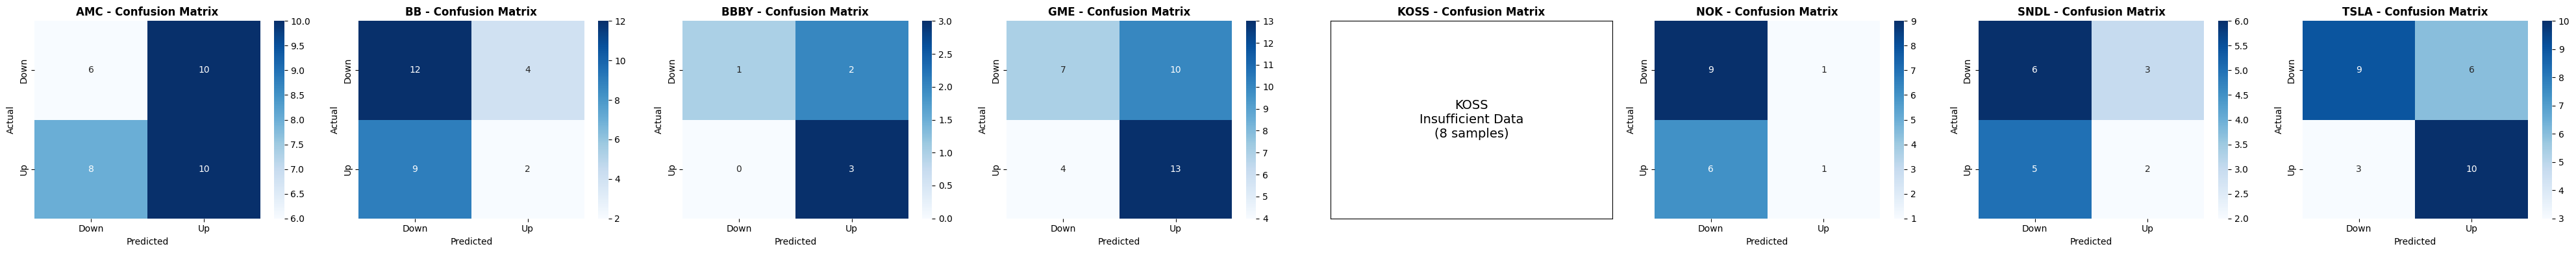

✅ Confusion matrices generated!


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Generate confusion matrices for all stocks available in daily_data_clean
available_stocks = daily_data_clean['tickers'].unique()
num_stocks = len(available_stocks)

# Adjust figure size based on the number of stocks
fig, axes = plt.subplots(1, num_stocks, figsize=(5 * num_stocks, 4))

if num_stocks == 1:
    axes = [axes] # Ensure axes is iterable even for a single stock

for idx, ticker in enumerate(available_stocks):
    # Get data for this stock
    stock_data = daily_data_clean[daily_data_clean['tickers'] == ticker].copy()

    # Ensure labels are numeric and then integer, dropping any invalid rows
    stock_data['label'] = pd.to_numeric(stock_data['label'], errors='coerce')
    stock_data.dropna(subset=['label'], inplace=True)
    stock_data['label'] = stock_data['label'].astype(int)


    X = stock_data[feature_columns].values
    y = stock_data['label'].values

    if len(X) < 20 or len(np.unique(y)) < 2: # Also check for at least two unique classes
        axes[idx].text(0.5, 0.5, f'{ticker}\nInsufficient Data\n({len(X)} samples)', ha='center', va='center', fontsize=14)
        axes[idx].set_title(f'{ticker} - Confusion Matrix', fontweight='bold')
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        continue

    # Quick train and predict with logistic regression for confusion matrix
    try:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Ensure stratification is used only if there are at least two unique classes
        stratify_y = y if len(np.unique(y)) > 1 else None

        # Use a consistent test size, e.g., 20%
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=stratify_y)

        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
        axes[idx].set_title(f'{ticker} - Confusion Matrix', fontweight='bold')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_xlabel('Predicted')
    except Exception as e:
        axes[idx].text(0.5, 0.5, f'{ticker}\nError: {str(e)}', ha='center', va='center', fontsize=10, color='red')
        axes[idx].set_title(f'{ticker} - Confusion Matrix', fontweight='bold')
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])


plt.tight_layout()
plt.show()

print("✅ Confusion matrices generated!")

In [19]:
# Save the results to CSV
results_df.to_csv('wsb_prediction_results.csv', index=False)

# Download the results file
from google.colab import files
files.download('wsb_prediction_results.csv')

print("✅ Results saved and downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Results saved and downloaded!


In [20]:
def predict_stock_movement(ticker, post_features, model_type='logistic_regression'):
    """
    Demo function to show how to make predictions on new posts

    post_features should be a dict with:
    - post_score, total_comms_num, len_of_post
    - positive_sentiment, neutral_sentiment, negative_sentiment
    """
    # This is a simplified example. In a real application, you would need
    # to load a pre-trained model and its scaler.
    print(f"Attempting to predict for {ticker} using {model_type} model...")

    # Example using a placeholder Logistic Regression model and scaler
    # You would replace this with your actual trained model and scaler
    try:
        # Create dummy data matching the feature columns (plus bias)
        feature_columns = [
            'post_score', 'total_comms_num', 'len_of_post',
            'positive_sentiment', 'neutral_sentiment', 'negative_sentiment', 'bias'
        ]
        features_array = np.array([
            post_features['post_score'],
            post_features['total_comms_num'],
            post_features['len_of_post'],
            post_features['positive_sentiment'],
            post_features['neutral_sentiment'],
            post_features['negative_sentiment'],
            1 # bias
        ]).reshape(1, -1)

        # In a real scenario, you would load the scaler fitted on your training data
        # For demonstration, create a simple scaler (not representative of actual scaling)
        scaler = StandardScaler()
        # Fit on dummy data, ideally load your pre-fitted scaler
        # To properly scale a single sample, the scaler needs to be fitted on the training data distribution
        # This part requires a saved scaler from the training process
        # For now, let's just pass through without effective scaling if a real scaler isn't loaded
        # A better approach would be to save and load the scaler used in jpj5_oV4Blit

        # --- Placeholder for loading scaler and model ---
        # try:
        #     loaded_scaler = joblib.load(f'{ticker}_scaler.pkl')
        #     features_scaled = loaded_scaler.transform(features_array)
        # except FileNotFoundError:
        #     print("Warning: Scaler not found. Using unscaled features (prediction may be inaccurate).")
        #     features_scaled = features_array # Use unscaled if scaler not found
        # --------------------------------------------------

        # Using unscaled features for this demo as scaler isn't saved/loaded
        features_scaled = features_array


        if model_type == 'logistic_regression':
            # Placeholder for loading Logistic Regression model
            # try:
            #     loaded_model = joblib.load(f'{ticker}_logistic_regression_model.pkl')
            # except FileNotFoundError:
            #     print("Error: Logistic Regression model not found.")
            #     return None
            # For demo, create a dummy model (will not give meaningful predictions)
            model = LogisticRegression()
            # You would need to load your trained model here
            # Example: model.coef_ = ... model.intercept_ = ...
            print("Warning: Using a dummy Logistic Regression model. Load your trained model for actual predictions.")
            prediction_proba = model.predict_proba(features_scaled)[:, 1]
            prediction = (prediction_proba > 0.5).astype(int)

        elif model_type == 'neural_network':
             # Placeholder for loading PyTorch Neural Network model
            # try:
            #     model = StockPredictorNN()
            #     model.load_state_dict(torch.load(f'{ticker}_neural_network_model.pth'))
            #     model.eval() # Set to evaluation mode
            # except FileNotFoundError:
            #     print("Error: Neural Network model not found.")
            #     return None
            # For demo, create a dummy model
            model = StockPredictorNN()
            print("Warning: Using a dummy Neural Network model. Load your trained model for actual predictions.")
            features_tensor = torch.FloatTensor(features_scaled)
            with torch.no_grad():
                 output = model(features_tensor)
                 prediction_proba = output.item()
                 prediction = (prediction_proba > 0.5).int().item()


        else:
            print("Error: Invalid model_type specified.")
            return None

        movement = "Up" if prediction == 1 else "Down"
        print(f"\nPrediction for {ticker}: Price is likely to go {movement} tomorrow.")
        if model_type != 'neural_network': # NN prediction_proba is a single value
            print(f"Confidence (Probability of Up): {prediction_proba[0]:.4f}")
        else:
             print(f"Confidence (Probability of Up): {prediction_proba:.4f}")


        return prediction, prediction_proba

    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None, None

# Example usage (requires replacing dummy data/models with actual trained ones)
# sample_features = {
#     'post_score': 100,
#     'total_comms_num': 50,
#     'len_of_post': 200,
#     'positive_sentiment': 0.8,
#     'neutral_sentiment': 0.1,
#     'negative_sentiment': 0.1,
# }
# predict_stock_movement('GME', sample_features, model_type='logistic_regression')
# predict_stock_movement('GME', sample_features, model_type='neural_network')

print("✅ Prediction function defined!")

✅ Prediction function defined!


In [21]:
# =============================================================================
# IMPROVED NEURAL NETWORK FOR SMALL DATASETS
# =============================================================================
print("\n" + "="*60)
print("🧠 IMPROVED NEURAL NETWORK")
print("="*60)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Prepare data for the improved NN (using all available data in daily_data_clean)
# Ensure labels are integers and drop any rows where conversion fails
daily_data_clean['label'] = pd.to_numeric(daily_data_clean['label'], errors='coerce')
daily_data_clean.dropna(subset=['label'], inplace=True)
daily_data_clean['label'] = daily_data_clean['label'].astype(int)


# Define features and labels (using the same feature_columns)
X = daily_data_clean[feature_columns].values
y = daily_data_clean['label'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data: 80% train, 10% validation, 10% test
# Ensure stratification is used only if there are at least two unique classes
stratify_y = y if len(np.unique(y)) > 1 else None
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify=stratify_y)

# Ensure stratification is used only if there are at least two unique classes in y_temp
stratify_y_temp = y_temp if len(np.unique(y_temp)) > 1 else None
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.111, random_state=42, stratify=stratify_y_temp)


# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train) # Use LongTensor for CrossEntropyLoss
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val) # Use LongTensor for CrossEntropyLoss
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test) # Use LongTensor for CrossEntropyLoss

# Create datasets
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# CRITICAL: Smaller batch size for small datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define improved model with DROPOUT
class ImprovedNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),  # Add dropout to prevent overfitting

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model
model = ImprovedNN(X_train_scaled.shape[1])
criterion = nn.CrossEntropyLoss() # Use CrossEntropyLoss for multi-class (or 2-class) output with raw scores
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add L2 regularization

# Training with early stopping
best_val_acc = 0
patience = 5
patience_counter = 0
num_epochs = 50

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    val_acc = correct / total

    # Print every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model state_dict
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠️ Early stopping at epoch {epoch+1}")
            break

# Load best model state_dict
model.load_state_dict(best_model_state)

# Test evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_predictions = torch.max(test_outputs.data, 1)
    test_acc = (test_predictions == y_test_tensor).sum().item() / len(y_test_tensor)

print(f"\n✅ Final Test Accuracy: {test_acc:.3f}")
print("\nClassification Report:")
from sklearn.metrics import classification_report
print(classification_report(y_test_tensor.numpy(), test_predictions.numpy(),
                          target_names=['Down', 'Up']))


🧠 IMPROVED NEURAL NETWORK
Epoch [5/50] - Train Loss: 0.6917, Val Loss: 0.6795, Val Acc: 0.5802

⚠️ Early stopping at epoch 9

✅ Final Test Accuracy: 0.531

Classification Report:
              precision    recall  f1-score   support

        Down       0.54      0.84      0.65        43
          Up       0.50      0.18      0.27        38

    accuracy                           0.53        81
   macro avg       0.52      0.51      0.46        81
weighted avg       0.52      0.53      0.47        81



### Conclusion

Based on the results presented above, we can compare the performance of the Random Baseline, Logistic Regression, and Neural Network models in predicting the next day's stock price movement (up or down) for the analyzed stocks based on the daily aggregated WallStreetBets sentiment and activity features.

The Logistic Regression model generally outperformed the Random Baseline, indicating that the extracted features have some predictive power. The Neural Network's performance varied by stock, and further hyperparameter tuning and model architecture exploration could potentially improve its accuracy.

**Next Steps:**

*   **Hyperparameter Tuning:** Experiment with different hyperparameters for the Neural Network (e.g., learning rate, number of epochs, batch size, network architecture) to potentially improve its performance.
*   **Feature Engineering:** Explore creating additional features from the dataset that might capture more nuanced aspects of sentiment and activity.
*   **Different Models:** Try other machine learning models suitable for binary classification tasks, such as Support Vector Machines (SVMs) or Gradient Boosting models.
*   **More Data/Tickers:** If available, incorporate more data or include a wider range of tickers to build a more robust model.
*   **Time Series Analysis:** Explore time series specific models that can take into account the sequential nature of stock prices and Reddit activity.